# Minimal Cut Sets (MCS)

The minimal cut set approach aims to find a minimum set of network intervetions that enforce some pre-definde behavior in a metabolic network. It may be used to suppress growth, suppress or enforce the synthesis of a certain product or to couple or decouple metabolic fluxes.

For the shown examples, we again load the COBRApy and the StrainDesign packages. As well as the small E. coli textbook-network "e_coli_core" and the example network "SmallExample".

In [1]:
import straindesign as sd
import cobra

ecc = cobra.io.load_model('e_coli_core')
model = cobra.io.read_sbml_model('../../../tests/model_small_example.xml')

Set parameter Username
Academic license - for non-commercial use only - expires 2022-07-13


## Example 1: Strain designs with a minimum product yield (1,4-BDO)

We may use the MCS approach to generate strain designs with a guaranteed minimum yield of 1,4-butanediol (1,4-BDO) on glucose. The following steps show how the function ``compute_strain_designs`` is employed to find MCS strain designs:
1) The production pathways, i.e., their metabolites and reactions are added to the model.
2) Analysis tools are used to identify adequate strain design goals. 
3) Set up the according strain design problem by specifying two strain design *modules*, one that demand the suppression of flux states with low product yields, the other one protecting the functions that are essential for bacterial growth.
4) The strain design function is called, passing the model and the strain design module as function arguments.
5) The results are analyzed.

##### 1) Add and verify production pathway

In [2]:
# Create copy of model to which pathway will be added
ecc_14bdo = ecc.copy()

# Add metabolites to model
ecc_14bdo.add_metabolites([ cobra.Metabolite('sucsal_c'),# Succinic semialdehyde
                            cobra.Metabolite('4hb_c'),   # 4-Hydroxybutanoate
                            cobra.Metabolite('4hbcoa_c'),# 4-Hydroxybutyryl-CoA
                            cobra.Metabolite('4hbal_c'), # 4-Hydroxybutanal
                            cobra.Metabolite('14bdo_c'), # Butane-1,4-diol (cytopl.)
                            cobra.Metabolite('14bdo_p'), # Butane-1,4-diol (peripl.)
                            cobra.Metabolite('14bdo_e')  # Butane-1,4-diol (extrac.)
                            ])

# Create reactions
SSCOARx    = cobra.Reaction('SSCOARx')
# AKGDC      = cobra.Reaction('AKGDC')
HBD        = cobra.Reaction('4HBD')
HBCT       = cobra.Reaction('4HBCT')
HBDH       = cobra.Reaction('4HBDH')
HBDx       = cobra.Reaction('4HBDx')
BDOtpp     = cobra.Reaction('14BDOtpp')
BDOtex     = cobra.Reaction('14BDOtex')
EX_14bdo_e = cobra.Reaction('EX_14bdo_e')

# Add reactions to model
ecc_14bdo.add_reactions([SSCOARx,
                        #  AKGDC,
                         HBD,
                         HBCT,
                         HBDH,
                         HBDx,
                         BDOtpp,
                         BDOtex,
                         EX_14bdo_e])

# Define reaction equations
SSCOARx.reaction    = '1 h_c + 1 nadph_c + 1 succoa_c -> 1 coa_c + 1 nadp_c + 1 sucsal_c'
# AKGDC.reaction      = '1 akg_c + 1 h_c                -> 1 co2_c + 1 sucsal_c'
HBD.reaction        = '1 h_c + 1 nadh_c + 1 sucsal_c  -> 1 4hb_c + 1 nad_c'
HBCT.reaction       = '1 4hb_c + 1 accoa_c            -> 1 4hbcoa_c + 1 ac_c'
HBDH.reaction       = '1 4hbcoa_c + 1 h_c + 1 nadh_c  -> 1 4hbal_c + 1 coa_c + 1 nad_c'
HBDx.reaction       = '1 4hbal_c + 1 h_c + 1 nadh_c   -> 1 14bdo_c + 1 nad_c'
BDOtpp.reaction     = '1 14bdo_c                      -> 1 14bdo_p'
BDOtex.reaction     = '1 14bdo_p                      -> 1 14bdo_e'
EX_14bdo_e.reaction = '1 14bdo_e                      ->'

# Verify that pathway is operational
sol = sd.fba(ecc_14bdo,obj='EX_14bdo_e',obj_sense='max')
print(f"Maximum possible 1,4-BDO synthesis rate: {sol.objective_value}.")

Read LP format model from file C:\Users\Philipp\AppData\Local\Temp\tmpgln1jpn_.lp
Reading time = 0.02 seconds
: 72 rows, 190 columns, 720 nonzeros
Maximum possible 1,4-BDO synthesis rate: 10.239127272727272.


##### 2) Analyze model and outline realistic strain design goals

We may plot the relationship between growth and product yield to get a feel for the production potential.

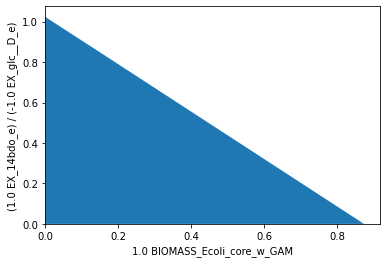

In [6]:
sd.plot_flux_space(ecc_14bdo, ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')));

Bacterial growth seems to compete with 1,4-BDO production. The maximum theoretical 1,4-BDO yield, is slightly above 1. We may now try to set realistic strain design goals. Assuming that knockout sets can be found the force a product yield above 0.3, while a growth rate of 0.15 is still attainable, we can specify according flux subspaces for protection or deletion through inequalities.

Since we decided to enforce a yield above 0.3, we aim to suppress all flux states with a yied inferior to this. Hence, we can describe the subspace of undesired fluxes with the inequality:
$$\frac{v_{1,4-BDO}}{v_{Glc,up}} \le 0.3$$
which can be linearized unter the assumption that $v_{Glc_up}>0$ to:
$$v_{1,4-BDO} - 0.3\, v_{Glc,up} \le 0$$

The flux states, which we aim to protect (at least partically) can be described by:
$$v_{Growth} \ge 0.15$$

We can use the plotting functen to visualize the flux subspaces that we would like to suppress (orange) or protect (green).

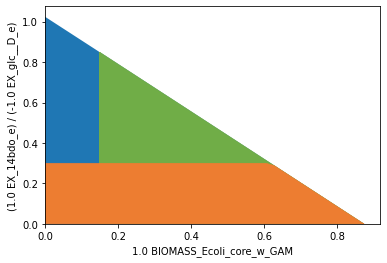

In [4]:
import matplotlib.pyplot as plt
# Wild-type plot
datapoints, triang, plot1 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')),
                                               show=False);
_,          _,      plot2 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')),
                                               constraints='BIOMASS_Ecoli_core_w_GAM>=0.15',
                                               show=False);
plot2.set_facecolor('#70AD47')
plot2.set_edgecolor('#70AD47')
# pGCP design plot
_,          _,      plot3 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')),
                                               # The sign of the glucose exchange reaction is flipped since 
                                               # reaction is defined in the direction of secretion.
                                               constraints='EX_14bdo_e + 0.3 EX_glc__D_e <= 0',
                                               show=False);
plot3.set_facecolor('#ED7D31')
plot3.set_edgecolor('#ED7D31')
# adjust axes limits and show plot
plot3.axes.set_xlim(0, 1.05*max([a[0] for a in datapoints]))
plot3.axes.set_ylim(0, 1.05*max([a[1] for a in datapoints]))
plt.show()

##### 3) Set up the strain design problem

The StrainDesign package uses so-called "strain design modules" to specify strain design goals. In the case of MCS, the goal is to suppress and protect flux spaces denoted by (sets of) linear inequalities. In the following we specify these modules.

In [3]:
module_suppress = sd.SDModule(ecc_14bdo,sd.names.SUPPRESS,constraints='EX_14bdo_e + 0.3 EX_glc__D_e <= 0')
module_protect  = sd.SDModule(ecc_14bdo,sd.names.PROTECT, constraints='BIOMASS_Ecoli_core_w_GAM>=0.15')

It must be noted that suppressed or protected flux spaces are not only denoted by single inequalities, but are always subspaces of the original model. For instance, the set of flux vectors in the "suppressed" flux space is constrained by the specified inequality
$$v_{1,4-BDO}^{supp} - 0.3\, v_{Glc,up}^{supp} \le 0$$
**but also** by the model constraints
$$\mathbf{S\cdot v^{supp} = 0}$$
$$\mathbf{lb \le v^{supp} \le ub}$$

We must pay close attention when specifying *protect* and *suppress' modules, as, in either case, we avoid to include the trivial flux vector $\mathbf{v = 0}$ in the according subspace. If the trivial vector is contained in the *suppressed* flux space, the subspace cannot be suppressed, since the trivial vector can always be attained, even when all reactions were blocked. If the trivial vector is part of the *protected* flux space, the module will be uneffective, since reactions knockouts can never be disrupt this vector. 

In the case of the e_coli_core, it is unnecessary to exclude the 0-vector explicitly, since it is already excluded by default due to the minimum ATP maintenance demand. If this was not the case, one would need a auxiliary constraint, e.g., $ v_{Glc,up} \ge 0.1$.

##### 4) Compute strain designs

We can now proceed with the strain design computation. Since we normally don't know if solutions to our strain design problems exist, we will start the computation with the most relaxed settings possible. This means, we compute only one single solution, within a given MILP timelimit of 5 minutes (for genome-scale setups, this should be increased to an hour), while omitting the minimality demand in the solutions and allow up to 30 knockouts. For this initial approach, we also activate logging to follow the progress of the computation.

In [7]:
import logging
logging.basicConfig(level=logging.INFO)
# Compute strain designs
sols = sd.compute_strain_designs(ecc_14bdo,
                                 sd_modules = [module_suppress, module_protect],
                                 time_limit = 300,
                                 max_solutions = 1,
                                 max_cost = 30,
                                 solution_approach = sd.names.ANY)
# Print solutions
print(f"One compressed solution with cost {sols.sd_cost[0]} found and "+\
      f"expanded to {len(sols.reaction_sd)} solutions in the uncompressed netork.")
print(f"Example knockout set: {[s for s in sols.reaction_sd[0]]}")

INFO:root:Preparing strain design computation.
INFO:root:  Using gurobi for solving LPs during preprocessing.
INFO:root:  FVA to identify blocked reactions and irreversibilities.
INFO:root:  FVA(s) to identify essential reactions.
INFO:root:Compressing Network (103 reactions).
INFO:root:  Removing blocked reactions.
INFO:root:  Translating stoichiometric coefficients to rationals.
INFO:root:  Removing conservation relations.
INFO:root:  Compression 1: Applying compression from EFM-tool module.
INFO:root:  Reduced to 59 reactions.
INFO:root:  Compression 2: Lumping parallel reactions.
INFO:root:  Last step could not reduce size further (59 reactions).
INFO:root:  Network compression completed. (1 compression iterations)
INFO:root:  Translating stoichiometric coefficients back to float.
INFO:root:  FVA(s) in compressed model to identify essential reactions.
INFO:root:Finished preprocessing:
INFO:root:  Model size: 59 reactions, 35 metabolites
INFO:root:  48 targetable reactions
INFO:root

One compressed solution with cost 10.0 found and expanded to {len(sols.reaction_sd)} solutions in the uncompressed netork.


##### 5) Analyze strain designs

We may plot the computed strain design (yellow) on top of the wild type model (blue), the suppressed fluxes (orange) and the protected fluxes (green). The designed strain is forced to produce 1,4-butanediol but is still able to grow at a rate higher than 0.15 1/h. 

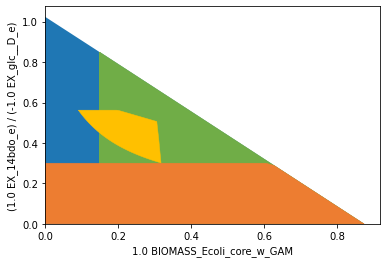

In [9]:
import matplotlib.pyplot as plt
# Wild-type plot
datapoints, triang, plot1 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')),
                                               show=False);
_,          _,      plot2 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')),
                                               constraints='BIOMASS_Ecoli_core_w_GAM>=0.15',
                                               show=False);
plot2.set_facecolor('#70AD47')
plot2.set_edgecolor('#70AD47')
# pGCP design plot
_,          _,      plot3 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')),
                                               # The sign of the glucose exchange reaction is flipped since 
                                               # reaction is defined in the direction of secretion.
                                               constraints='EX_14bdo_e + 0.3 EX_glc__D_e <= 0',
                                               show=False);
plot3.set_facecolor('#ED7D31')
plot3.set_edgecolor('#ED7D31')
# plotting designed strain
knockouts = [[{s:1.0},'=',0.0] for s in sols.reaction_sd[0]]
_,          _,      plot4 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')),
                                               # The sign of the glucose exchange reaction is flipped since 
                                               # reaction is defined in the direction of secretion.
                                               constraints=knockouts,
                                               show=False);
plot4.set_facecolor('#FFC000')
plot4.set_edgecolor('#FFC000')
# adjust axes limits and show plot
plot4.axes.set_xlim(0, 1.05*max([a[0] for a in datapoints]))
plot4.axes.set_ylim(0, 1.05*max([a[1] for a in datapoints]))
plt.show()

In [8]:
			prod_id      = 'EX_14bdo_e';
			species(1)   = struct('spec_id','4hb_c','spec_name','4-Hydroxybutanoate','fbc_chemicalFormula','C4H7O3','fbc_charge',-1);
			species(2)   = struct('spec_id','4hbcoa_c','spec_name','4-Hydroxybutyryl-CoA','fbc_chemicalFormula','C25H38N7O18P3S','fbc_charge',-4);
			species(3)   = struct('spec_id','4hbal_c','spec_name','4-Hydroxybutanal','fbc_chemicalFormula','C4H8O2','fbc_charge',0);
			species(4)   = struct('spec_id','14bdo_c','spec_name','Butane-1,4-diol','fbc_chemicalFormula','C4H10O2','fbc_charge',0);
			species(5)   = struct('spec_id','14bdo_p','spec_name','Butane-1,4-diol','fbc_chemicalFormula','C4H10O2','fbc_charge',0);
			species(6)   = struct('spec_id','14bdo_e','spec_name','Butane-1,4-diol','fbc_chemicalFormula','C4H10O2','fbc_charge',0);
			reactions(1) = struct('reac_id','SSCOARx','equation','1 h_c + 1 nadph_c + 1 succoa_c = 1 coa_c + 1 nadp_c + 1 sucsal_c','lb',0,'ub',1000,'fbc_geneProductAssociation','sucD_Pg');
			reactions(2) = struct('reac_id','AKGDC','equation','1 akg_c + 1 h_c = 1 co2_c + 1 sucsal_c','lb',0,'ub',1000,'fbc_geneProductAssociation','sucA_Mb');
			reactions(3) = struct('reac_id','4HBD','equation','1 h_c + 1 nadh_c + 1 sucsal_c = 1 4hb_c + 1 nad_c','lb',0,'ub',1000,'fbc_geneProductAssociation','4hbD_Pg');
			reactions(4) = struct('reac_id','4HBCT','equation','1 4hb_c + 1 accoa_c = 1 4hbcoa_c + 1 ac_c','lb',0,'ub',1000,'fbc_geneProductAssociation','cat2');
			reactions(5) = struct('reac_id','4HBDH','equation','1 4hbcoa_c + 1 h_c + 1 nadh_c = 1 4hbal_c + 1 coa_c + 1 nad_c','lb',0,'ub',1000,'fbc_geneProductAssociation','adh2');
			reactions(6) = struct('reac_id','4HBDx','equation','1 4hbal_c + 1 h_c + 1 nadh_c = 1 14bdo_c + 1 nad_c','lb',0,'ub',1000,'fbc_geneProductAssociation','adhE2');
			reactions(7) = struct('reac_id','14BDOtpp','equation','1 14bdo_c = 1 14bdo_p','lb',-1000,'ub',1000,'fbc_geneProductAssociation','');
			reactions(8) = struct('reac_id','14BDOtex','equation','1 14bdo_p = 1 14bdo_e','lb',-1000,'ub',1000,'fbc_geneProductAssociation','');
			reactions(9) = struct('reac_id','EX_14bdo_e','equation','1 14bdo_e =','lb',0,'ub',1000,'fbc_geneProductAssociation','');

SyntaxError: cannot assign to function call (370745334.py, line 2)

## Theoretical Background
The concept can be viewed in a small example network:

<img style="float:left; width:30%" src="../img/SmallExample.svg" />

### Example 3: Suppress fluxes

Suppose, we want block all metabolic flux through **R4** to avoid the production of metabolite **E**. One can now identify irreducible sets of reaction knockouts to achieve this. Each of these set is called a minimal cut set, short MCS. This figure shows all possible MCS for blocking reaction R4.

<img style="float:left; width:70%" src="../img/SmallExample_mcs1.svg" />


Set up the according strain design problem by specifying a *module* that demands the suppression of flux states with $R4 > 0$. 

Since strict inequalities are not allowed in mixed integer linear programming (MILP), we need to approximate it by an inclusive inequality and a sufficiently small value $\varepsilon>0$. Here we pick $\varepsilon=1$, such that the flux states that we aim to delete are those that fulfill the inequality:

$$R4 >= 1$$

In [ ]:
modules  =  [sd.SDModule(model,sd.names.SUPPRESS,constraints='R4 >= 1')]
# modules +=  [sd.SDModule(model,sd.names.PROTECT, constraints='R3 >= 1')]


sols = sd.compute_strain_designs(model,sd_modules = modules)
for s in sols.reaction_sd:
    print(s)

{'R1': -1.0}
{'R3': -1.0}
{'R4': -1.0}
{'R7': -1.0}
{'R10': -1.0}
{'R6': -1.0, 'R8': -1.0}
{'R2': -1.0, 'R5': -1.0, 'R6': -1.0}


An adequate value for $\varepsilon$ can inferred from the model, i.e., the coefficients of the stoichiometric matrix and the flux boundaries. In the shown example values of 1e-7 up to 50 will yield the same results. However, too small values may result in longer runtimes or numerical issues. While large values may not approximate the strict inequality well enough.

### Example 4: Suppress and protect fluxes

It may sometimes be required to protect certain flux states, 

In [ ]:
import straindesign as sd
import cobra

model = cobra.io.read_sbml_model('../../../tests/model_small_example.xml')

modules =   [sd.SDModule(model,sd.names.SUPPRESS,constraints='R4 >= 1')]
modules +=  [sd.SDModule(model,sd.names.PROTECT, constraints='R3 >= 1')]

sols = sd.compute_strain_designs(model,sd_modules = modules)
for s in sols.reaction_sd:
    print(s)

{'R1': -1.0}
{'R4': -1.0}
{'R7': -1.0}
{'R10': -1.0}
{'R6': -1.0, 'R8': -1.0}


To see the current status of the strain design computation, import the logging package and lower the reporting level.

In [ ]:
import logging
logging.basicConfig(level=logging.INFO)

[]

Continued..

## Computing synthetic lethals

## Computing production strain designs